## 물고기 분류기

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pathlib

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)

In [3]:
# 데이터셋 불러오기
data_dir = pathlib.Path('./dataset')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


323


In [4]:
batch_size = 32
img_height = 250
img_width = 250

keras.preprocessing = 디스크의 이미지 디렉토리를 `tf.data.Dataset`으로 가져옴
= 그냥 이미지 로드해주는 애

검증 분할 = training:validation 비율을 8:2로 정해줌

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 396 files belonging to 6 classes.
Using 317 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 396 files belonging to 6 classes.
Using 79 files for validation.


이러한 데이터세트의 `class_names` 속성에서 클래스 이름을 찾을 수 있습니다.

In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
print(num_classes)

['catfish_메기', 'crucian carp_붕어', 'flatfish_광어', 'golden mandarin fish_쏘가리', 'red snapper_참돔', 'rockfish_우럭']
6


### 데이터 증강
과대적합은 일반적으로 훈련 예제가 적을 때 발생합니다. 데이터 증강은 증강한 다음 믿을 수 있는 이미지를 생성하는 임의 변환을 사용하는 방법으로 기존 예제에서 추가 훈련 데이터를 생성하는 접근법을 취합니다. 그러면 모델이 데이터의 더 많은 측면을 파악하게 되므로 일반화가 더 쉬워집니다.

여기서는 실험적인 Keras 전처리 레이어를 사용하여 데이터 증강을 구현합니다. 이들 레이어는 다른 레이어와 마찬가지로 모델 내에 포함될 수 있으며, GPU에서 실행됩니다.

In [8]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

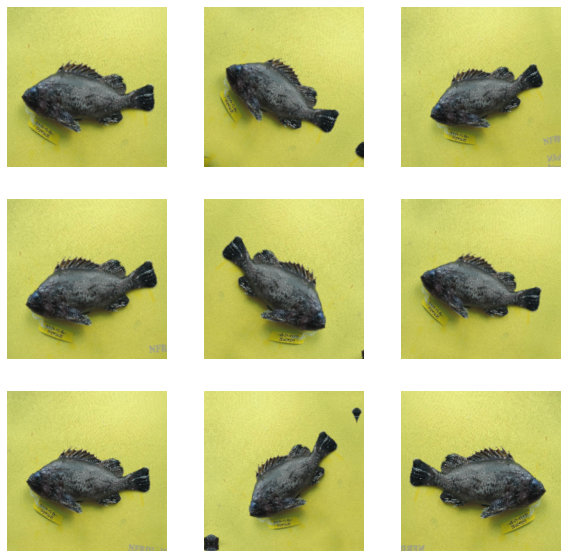

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(2):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 250, 250, 3)
(32,)


`image_batch`는 형상 `(32, 180, 180, 3)`의 텐서입니다. 이것은 형상 `180x180x3`의 32개 이미지 배치입니다(마지막 치수는 색상 채널 RGB를 나타냄). `label_batch`는 형상 `(32,)`의 텐서이며 32개 이미지에 해당하는 레이블입니다.


참고: 이들 텐서 중 하나에서 `.numpy()`를 호출하여 `numpy.ndarray`로 변환할 수 있습니다.

### 데이터 표준화하기


RGB 채널 값은 `[0, 255]` 범위에 있습니다. 신경망에는 이상적이지 않습니다. 일반적으로 입력 값을 작게 만들어야 합니다. 여기서는 Rescaling 레이어를 사용하여 값이 `[0, 1]`에 있도록 표준화합니다.

In [10]:
IMG_SIZE = 250

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

이 레이어를 사용하는 방법에는 두 가지가 있습니다. map을 호출하여 데이터세트에 레이어를 적용할 수 있습니다.

In [ ]:
# data_augmentation = tf.keras.Sequential([
#     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#     layers.experimental.preprocessing.RandomRotation(0.1),
# ])

또는 모델 정의 내에 레이어를 포함하여 배포를 단순화할 수 있습니다. 여기서는 두 번째 접근 방식을 사용할 것입니다.

참고: 픽셀 값을 `[-1,1]`으로 조정하려면 대신 `Rescaling(1./127.5, offset=-1)`를 작성할 수 있습니다.

참고: 이전에 `image_dataset_from_directory`의 `image_size` 인수를 사용하여 이미지 크기를 조정했습니다. 모델에 크기 조정 논리를 포함하려면 [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) 레이어를 대신 사용할 수 있습니다.


### 성능을 위한 데이터세트 구성하기

버퍼링된 프리페치를 사용하여 I/O가 차단되지 않고 디스크에서 데이터를 생성할 수 있도록 합니다. 데이터를 로드할 때 사용해야 하는 두 가지 중요한 메서드입니다.

`.cache()`는 첫 번째 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.

`.prefetch()`는 훈련 중에 데이터 전처리 및 모델 실행과 겹칩니다.

관심 있는 독자는 [데이터 성능 가이드](https://www.tensorflow.org/guide/data_performance#prefetching)에서 두 가지 메서드와 디스크에 데이터를 캐시하는 방법에 대해 자세히 알아볼 수 있습니다.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

### 모델 훈련하기

완전성을 위해 준비한 데이터세트를 사용하여 간단한 모델을 훈련하는 방법을 보여줍니다. 이 모델은 어떤 식으로든 조정되지 않았습니다. 목표는 방금 만든 데이터세트를 사용하여 역학을 보여주는 것입니다. 이미지 분류에 대한 자세한 내용은 이 [튜토리얼](https://www.tensorflow.org/tutorials/images/classification)을 참조하세요.

In [25]:
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

참고: 몇 가지 epoch에 대해서만 훈련하므로 이 튜토리얼은 빠르게 진행됩니다. 

In [27]:
epochs = 50
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)
hdf5_file = "./model/original-model.hdf5"
model.save_weights(hdf5_file)

Epoch 1/50
10/10 [==============================] - 2s 132ms/step - loss: 3.4805 - accuracy: 0.1965 - val_loss: 1.7952 - val_accuracy: 0.2785
Epoch 2/50
10/10 [==============================] - 1s 111ms/step - loss: 1.7495 - accuracy: 0.2626 - val_loss: 1.7684 - val_accuracy: 0.2278
Epoch 3/50
10/10 [==============================] - 1s 112ms/step - loss: 1.6456 - accuracy: 0.3369 - val_loss: 1.9335 - val_accuracy: 0.2405
Epoch 4/50
10/10 [==============================] - 1s 117ms/step - loss: 1.5828 - accuracy: 0.3808 - val_loss: 1.9472 - val_accuracy: 0.2152
Epoch 5/50
10/10 [==============================] - 1s 111ms/step - loss: 1.5632 - accuracy: 0.3372 - val_loss: 1.5697 - val_accuracy: 0.3671
Epoch 6/50
10/10 [==============================] - 1s 114ms/step - loss: 1.2815 - accuracy: 0.5305 - val_loss: 1.5064 - val_accuracy: 0.4430
Epoch 7/50
10/10 [==============================] - 1s 112ms/step - loss: 1.1943 - accuracy: 0.5269 - val_loss: 1.4876 - val_accuracy: 0.4810
Epoch 

참고: `model.fit`을 사용하는 대신 사용자 정의 훈련 루프를 작성할 수도 있습니다. 자세한 내용은 이 [튜토리얼](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)을 참조하세요.

검증 정확성이 훈련 정확성에 비해 낮으므로 모델이 과대적합되었음을 알 수 있습니다. 이 [튜토리얼](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)에서 과대적합 및 축소 방법에 대해 자세히 알아볼 수 있습니다.

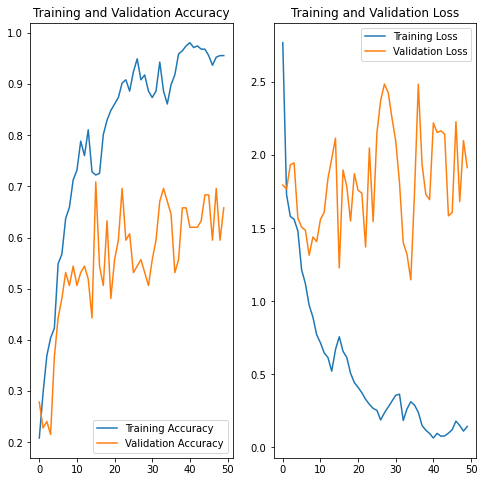

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
catfish_url = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBcWFRgWFhYZGRgZGhwcHBwcHCQhGh4cHBoaHh8cIRoeIS4lHh4rHxocJjgmKy8xNTU1HCQ7QDs0Py40NTEBDAwMEA8QHBISHzQrISQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NP/AABEIAJ8BPQMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAACAwEEBQAGB//EADgQAAECAwUGBQQCAgICAwAAAAECEQAhMQMEQVFhEnGBkaHwBSKxwdETMuHxBkJSomJyFdIUI4L/xAAZAQEBAQEBAQAAAAAAAAAAAAAAAQIDBAX/xAAiEQEBAAIDAQACAgMAAAAAAAAAAQIRAxIhMUFRE2EEIlL/2gAMAwEAAhEDEQA/ALIUcJjnEbXc5wai0nPM1HCAUBVi51j7L5piQc23vECzJdy/OOCTgMe3g9v8/rGCo+nhMnd8xybNnoYkK0PekRMF2G+AatJDAAb29IDZng54NElBPuxiFpJxDesQGpCQzlzvgfmn6EChBBq8cQqfx+YCQXqH3xY2Qd4yEoWlDgAkPpE2VnPjAClc2GXGkMWHDud3vArX5sBWWNRNoi2tUgpEyT5QxbUmJtdCBVgVNHFJLgimohaVpALuJPPTfC0WqVUM6s8xpE3BZ4DvWIK506TlKK6LygkpDFQMwfWeRGFIaSC+Ehr0wiyjkliZDus4NxizaGEuKTbcOczDFGUn5fGMBxDnDgYggzJD9nCATmVEyo3o8NkzCm5+MBASSJFtaH0iUWTFt0qcXEKTJ3Pf6gkOWrpU9GgAUjWeTtjk0SE5hL9fjOJmTP07lA7P+LmszSA5SpOwOe874BJA+6tBPKmEGRj0l7iFO1SG0iWqakhmAD5tPdTuULdiTId7o4KlgBljEWhyI3Ezyhs0UCFN5g+DRJmTI7mhgQGrxk55dzjlLwYmNT4UCHoSeIkOBiVqMjWBNqwZj0d84BawQ5E6cdYm00lTH37BiEuAzS0PvELIag5e3zEItBkaaN+IbXSC4/fLWEKJd9ndPrWLKFieeULStjhx/UApSATiIAWZqJviSPiGrDu27ucKXaiVeDwGug5pP73NEGzmGDfHKsACczzlyxg0vjPvGcaZQhE3Zhm/4nBrVlAKIykKOI4b/gct0AaVYsW4PEpWMBPX2jtoHEQQCZ0fhEEbc5y6CC2RQy5wCqliG0iWNKDM/gdvAcFhsWf00g1Gk659YWEsCxOZiAqTqEsycN8QGSXDEevOeUAq+rCwgbNCTuBaKd/vJQgqSoyUmTYOHxxEZN5dZCwCJzaTJGGmMcs+SY+OmGHZoLviwtS0qAbyszpIBem8mcoRfVlfmXViwEm1GRrOGOlIqGiveb0nFtmnsI4XPz12mE/BdkbQoYqUwo5J9YdYWagG2iBjxwEBZ35FCQGw3+7wdpeQkEqObYPzjHZdKf1C/lBCgZF2I3N3OGrt1pUVlRJauHJukDY3lImWBOtPmF3q8hUhIGv4h3s/LXWUfhfjq1L2VsEKYAsZHIVmXrIBo3LDxlCgQF4t9pHqKR5xCEKoBI5xF6syUlNmWLMTh3pG8ea4/fWLx4349gFk6YU1ygVEl/MeGfHuUea8N8RWjyr21yDEbJOoLke8at38TSskAqS0y7AtnJ9I9GPJjk45YWNLZlUy3OIJKjgd27rGHevG0JLJ2lmU38o1fEtlGZffH1qkPInf5juq3c4zlzYz8kwyr16ho5x7Z4g2qhQSzJn0rHhbPxVaFbQAOiiquZ8z8DHpPB/FE2gmwXikOW1GYi48kyMsLGnsP+4EICX6N6xNopnAHSOKiJGu6Om2Upsw8yCd04G0QkYjXd+veAWSwIDaHjnxiSpXbY6xQpQbFzu6V1jgsf5CeDfmJU4qe+AgJ4s2kz7RNroQABfiHAqesQVPVtJj0iCgnQat8wP03keLD4ippIYDTd+IFS3kNmmQaGlGDp4vClJYyKRrM9ICCAatvAEKXZpTPlIHoBDHUZ1fhwgVlTt6kekAq0TIs/SXB5QIIxHp7wwul6cw8sIizSWfarBWghM675Z4QS1Nyo/vEIWSdN/thBppSfeYjTABOs+EEuxac67hAgNM16wSkEzlp3nAMmcgNCHeIKBmRqTOOkKFM+8YgqNKnkIgnZYV4PjHFMstfzEFRxblvx5RnX3xJFlNSgVU2U+Yvkzy4xLZPaslvxpAjKXSKN7vdkg+dSK/aCSQf+ojBvHittaEgJKE5ULanjuikvw5ZLqMtD75R58ub/mOuPF+6t+M+NoWNhCDUHaNZF5BzlGZ/wCQUU7JJxmJVwfjF2y8KSCyiTMmZw0OTE5xfsblZAfbyDmkefK5ZXdd8ZMZqMS0vq1BiXYDLDSE3i9Ghy5R6Fd0sxIAng9XfANu1ipa+H7U0p3vLP56RzsrcsYarQkyoNfT5iwrbKSSRJqkPPHNqQ+8XIsDs4OCCGL8d8GuwOyXSrF5F3OGWJ5CUZa0pWRBLSEnBL4YPgfmHWi5FidSaibyPSL11u6BNmOIIk5POhruhpugFGKTrPAn0MvWMrpiItlAyUZdJTh9l4ipMneZixebMIPlYhQZ8u6xRXdgCDRz8SI7+RpZu3iBc699iHWluTVneoGEVLS6lJLBiJ6nCta4HPhArC01D9+kN06w1ay9M4Qm1wnznxOEQi9FNRuemZ6NHWi0rm4fr3SHZLihT1SmWQBPFzDblfjZrClbYAqxmfR4SEB22nbukLvNls4J3sHjpjnZfHO4vovh3iCLVAWh2NcCDkQC0PUtJZ5HV+cfOvCfFDYrJqk1AIHIOY+g3K3QtIWCkpIcNPnOse7j5JlP7ebLHVNKE1pw/NIEBzJuI61nB2iE4kBt+elYMENIOPbdHZglQAwBzaEqajgcIaQQSA7ZY9YhIkTN+84AELYPU5s8CbUHEbmnBlAL+YHeXiveL4iyB21gaYn/APNThE+fVSm1xY1w/Ucu0Bq85P64R56/fycB9hE81f8AqPmMdfjl5WdlKyHNAB6gSjnebGfPW5x2vaL2QROU8GgvqplQ4V6RjeGXBeztWlotRy2jzkY105SBzOm/3jeNtm9aYskClY+B1yia4PwiChsXPVuEcUvOu5j7xpGklQ1O6Dkcx6wlIc/ca8IYbQATJOj+8aZchQSWUkmCCzgAB3lCkrDTBHe6ItLRKU7RMhV8BnE2GoUaq2fiBt70EB1KCUj094xL7b/VPlUUoP218zVUWILPIDR48z4ndSlbJOj5nHEn9Rwz5rPkdcePf2tPxr+TFflsgwxV/Y7v8R1jHsSpwSSzu2JOZhtwuCikrAo5L10Ea118NYOoPRzUB6yjy5Z3L2vRjjMfIrqvQ2UpBLYly/CLVyviVEIB2iJTkuju2InDbPwIr8w/yZhg8w5hNp4IlHnKylaZpYsX3z/UZivQXXwkK82BPEHET0xiza3RCEqIDEAsTKXfOM7wT+QAAIUBtlwFOwO/Vg2UWLa9KWp0JJEgQWILlxjOcLkvUq1IOBYk/wCy3adcn4RIu7sJORPWRJORLqpjF66XQkOoeXB8SKk5faB+oXaWVUgkEMz08zD1HMxnf7NM2xujnYJkHwcAsupMnYSlpFi0ubmVA82kZK+1988sIu2VySlIKVSM5mbMrDEaYEmLd3sWUzu5nipgQ40MjPhEqs9dyBYJSRPCbksA2HHHgIrXy4lzsyIIdtHnMY7KfePQWagxcuRMyYyY+VxTzA6F84QUOpSiCD9u/wC6U9ZcIlix5a3uIckpO8hsZkDtqQhNzSSRq7EZkmub5CPS3iwdwljnjOWPfSFJukgcOsgJa1nGdNbeeVZqMymTjZnvGOJmzviJiUVloxUmYGVWx4x7O0uqWaoD+hmNJxUtrhNv6vwaXXXjDRt5K0uySnaZnmzTdg/pGVbWIdxKtKV77nHsLx4eVUDM9JUAee894Z5ugk4mGw77MTRt5wJUC4M2iRarEjMUjWFwD6k19ukKtbjs/b5sThyhql0qIuoWfKCNO6jWNHwv6lgorR5kD7kguDwNDKKCLFYkEkg1/eFd0W0ILETBNcjhPHT4x3jncbti47mnqbn4km0S6VBjIvUaMYtJINUn13R4a0sFAugqSaOJYmXOGWN8vAkVqbMsTzIePVj/AJU/Mcbw38V628X5CB51bJ1ZzowEZl58fQkHYQVHMkAZ6n0jz9s5PmmesMtLNLDOrRMufK3zxZxYz6tW3jdqRIhA0E+r84xLW1KiSCSTVRrzhl4r2ekSwODxzuWWX2tak+KR3vF3wK7ldqGNKSf8CE26NG4j2i9/HCfqAAyYuHlpGsJ7Gcr5XsUJkBLh8QQqzzy4ZPBgMczkG/fWItCWPlJB3R7tPMTtNVUzvgy+R4P8RCA2fL4gnOEx3lFF5QmDsgaH5ibMvUT0p6QKFkZmGJMpsW7dorIVrAHmEgHdzLpHk/F7e1tgoGSE0CT95wJnPDSPQeIbZ8oaYc85NPMdYr3fwxBmpx/k2BJkdRHl5s93Uejiwn2sfxUFaEFCglKUgOMKuFAUM4x7GyO2Bt7bZUBpUxr+P+GpQxKHZxtJUfNRiR8Zxs//AAxY+RAGyySzbyCWGWBaOH+127WSGWd1ayIcSYEtid0X7gobE0uJ4TU5k+6UY94tVJQpGH3EjR+ka3hV4azQHBKwA/AzaM4+TRY1bpZpQNpUmeQxMqnJjTdm0eR/lVtsArLAEkITiXI6Bo9RbXlNiFBZGyASou7MXYZPIanfHzD+VeIm2W5GyKBP+Kct+J1MS/urP1Fe5LdW2ol8Gpw0j238cvSVBv7TBcuQRQ1jx1zuvldjIyAixdrzsLCgTtdN2sZa2+lXlYCXwlwryko8oyL5f0SY7WYFC064gluUeft/Elq+47Xpyita31WkN1NN218Y2VOhLTxaXYiLr4uUqcJEyTjiSW1E48+m8E1EWbttn7RyHvE9XT1SPHUbTqSUkUIAbk7ndF6y8SslNNjINiZktPuceZs/DVqqC2/4hqfD0IHnWH0LnkYerI9GtaZyGjTGDT3tHJLJc5hznTlGNdVhwzhP/L4EhGgbXd20JdlSu38oAl6/1lA2t4BSqfm2c2z5RXtluFNWvJviM+xd88OgHe6MetLiVhJmXBwyIJwrNhWkJUpLiYIDEjcUjvdpEW6FbQWAzGY49fuiraWTrAnP4POkLLE+rX00bZcsCQwwqC/NxLKFrugkMwTKVA+UOsri8lfruXKLakgtmMY3jhazcoyxc0lNJgTB9fzDbO6IcHBqPz0i6qym+H6ivaMP7AZd8I6fx1ntCr3dkAOBtCXScZq60kn5aLtre7MVWkcRwjHXfEbY/wDsHF2pObNlF1YblHeVq/xBFMKtnFRa3QPLLdGsq4FSRsqBBGBdxGNfFlBCTTsRbue1PPwQlIP9tnRoApH+T95QpVp2e5Qm2tBinl8xNxLC7yojLrGz/FLN1lThwGZjjjQRiLL0J4x6X+HqQ6wE+YAZEHUZUjfHN5RjLzGvR7JnJjV2od0Es73bLthErcTY7x28LUtTSOs49zzuE6s7917nHbLYDLlxiA5kaZvjnWBtCxY8zjBGo03oc3rwEQohwXlWQgbMMfuGj0/cQlnq55PzioJeypj7UdssYKzBQsKT5hka6pPzuiLQtIdtAJtJzm4mH3YiYOsc88O0/t0wy61St0la1KUHQDIHKbjVg3KHWV1UMQUKocd0+M4toRtgpkUjORG/PCcXbG7oKQhYVI1qH3tHkyxuM09Uyl9Zd4QFqCalKZykwI0nBbYswllf1MmZiHYBtBXXhF682qEHYQNokAO8hvJwrR4oWl22nJmBUmQllGN1bpj+JWqliZZAnP8AsRPaOYFY8ZZo+qsq/qCTHp/5NbEIKEVVLVse/iKvgnh52QN/pnGMquJqriRZJUgTxwMVv/HrLkpIlHrrOwkA8jhhh1iveQQGH55YfuJrxdvN2d1c1JEXrLw7MS0HvhGhdLiT7yjQV4fvJFHpuni8U3FO6XJA/q5Pe8RcVaIs8HVkGcbyKQavD1FM1MNO90LNgQoDZnj3nGtZVntEWqlrcE7Gg9zWEIuYBY46dtFq2sDIPPfx5RZRYszz+JwmH7Oysm7sd1P3AfTUFUcd4RopOneXTrHLSGfHPhDro2TZXcOTFe2sRtBhu0ixZqM3MNDRZJS1W2ApsohNh5niwtGUoBb/ALM2zjfVOwNhLu7+kEmzUZgMMzCzeUInU94RSvXi8nJYcj1lFmMZuTvErwEAuoK3q2E82MeUvSQtb7SJyASpShzYYxbvN6CphY/6rQ/WIuwJW5QnKQCeQrpCTdTZ908NRXYf5HGLifD0YpG6Tw+7uBm/dOcWSkjEN0pHoxxmvjjazj4OB50LUg6e4ZucUvELishiAsYKElcRjHo1AgSIPDukSHxD6fvGLcMaTKx81tUFJInxHsYSVR9Cv/haLVM0AE/2H3DpOPK+Ifxxdn5k+dOgmN4+I82fDlj89jrjyS/WDs5FtI3/AOLXsIUQoO8gXPeMYlomG+E2xFoAC08TLnhGMb1ylaym4+jBYNHpEJLl+/WIuhITlpg0EXZquWJ/Ee+evK5axg8g35eFLMhq/dYYpNE0bkWhalEYPu/Bi1I0G0IPCGBIG890iElx93ID2iAtqV3RUEtOoGf6aF2mM33Y9J5wxCQqqTECyqyWfH9wFe0SoHaEmozBqYvlFi7+KKQCCkkaElQ5wKrHNi1GVCbUTaXP2jGWO25lpbT4jZMyiRj5hj1ETeLyFpOwdvJj8U3xmruwMyNNMM4pLu7qGzLJnYbjHDLi/TrjmuWfhwV9wm70yoN0aFy8O2A8YFoi0BDLU41V7xYu/i9siSiFgZhjzEcv4fW+/j0ZupHmluiurw8LLrVuAkPkxVsf5IB91mobp/EWkeO3dUiSk6g+0JhIdqfd7BNn9oEWXCmI4iKyr3ZKSpSLRKtlJUQJkJFS1YzE+Jq2hsIKgcRC2Twktb2yGpw73QKEBi7RWQLRX9P9hE3hNokOEPuI92EWWFlWlITA7AEebvXjqkFlWawdWA5h4pr/AJBaKklKRvJPxF2mnqLRQEZt/wDE0IHmUHqEvPgIwl322WJrb/qG/PWEoubzUz548YdbV2i0/kNqT5EpA1cn1EMuX8iWlaVLCFIfzBIIO8TM9INF10A0iFXEMNcIfx07vRXq+uhS7I7SWdtN3dDGKnxhKyGkWoTPnlFeysl2fmSSCPerjKIvFghZCtkJV/YAAA4ulvSLcadoO+2yqlJCR/YF2GD/AIjKt7ypY2VpC0VC01fURq2VgpI2QS3+vKFLuoBoxOKTXeDGeuUO0pFyVZqYOxkz0M6CXSNFF2Y56DCUVbK7FwJEEzBEt88Y10JwBpSXYjthPPXPKhskkM4A5UyhoSlzUHvHOOQM2fRp9vjD17JZ46xilAScDn+IYizcUG9/mOSjANlX9RKsm5Me8OkWI5SDMA4UH4gaFn+H4GkEA+B5dYEpm3sYqMu/+D2Fp9yWX/kksfg8RGFa/wAUWlQUhQWBgoEDioEe0eu2mMmf4wnBIUqol3lGMuPHL7GpllFLw4LCClciJAPtdZNhyi2tBbn6b2gkJzA94ANQS30aN4zUZvtKQti+edZNhA2xnlDVob+obN+3xgdhOUSi+hYxiQZuOggEl6Od/q0ElRebN77o2yMrJono8QpzjwaO+oRj3wiDbF2LkRAVmk4b+w3bRyiTn6QONABw5QaVk0dusAlViTSAXYgYj0iypFZbuzArsD90zujNaZyrKZm+WW+cQq7SeT1fOLxsnp1Z5wH0AAxB5xLi1KorugP9nAlJvWEG5gGWsan0Wevr3jEGzoJONWjNxWZM+7WarNYWlIkZzqk/ck6EOIvXdrK0/wCC5oVk89nm/HaiTZHFjpvhibELSUKcAzSf8VDLQ+vGOHJhbNz7HXDPV9a9he0qBCkhYGBkofIhS7VCjspASRhRoxkAnyKUUWqCxVgRgSMUtLhF2wtC+ysAK6HURjD1vLxneMotP7pQ2BGW+KAsBXTvvdHoL6l0EEsC1dDhGShCaBn4x6NOO3JQnIzwhqEJEyk+05QaUbhp3rHKBLOR22sXSIJBk3GCFiBnXh6QSrIj+3w+7vGCCMSs8BKKySbNO4/gfqJXYJkZg7veH7AJrPdB7IxNOcXQqJsfLIndJzOC+lSR3tFhCEu/lfMibcIhVkqbazBNPiLoV7OzSMAOEMCC33S5n1hgQ1SOf5gRZ5kOO8+ENCU0ba4MIlbGoOGGu+IAJGAO9pQSwQGBEp1lGkQdkGZHGus3gxsn9ktzgEJW1E6zJ9Yn6ZJduUECq0mWI73QSqOTh28QKu2WHvALkc9wdtYDiHw75wJRKQw9ogCbim4wC2JqxFSIASrQ6/sGOSTOT+schWpPHtoFSnYkk8a8IAmVgD78WhagrIQW13o9eULWHwpAayCDTolyYEECoafFt0dMyG1nErSDgCd/5jTKUWk6cTHKOaRziE2eASMKTgysjLe1axBxtCBMDhHJMn9vaIBx+GypBoWAPtOopEUIS9CTnIsIgkzkT0bWGhZaYSO9IhSSZunDCClF6uw3+8ApBOJ5+8WSciOU3gCCMaaN7wUjYJz59mIKVDeKB4sqgQBo2E8eETS7VzZqUS6ROZYyiFXU5CkPtiZenvALNH7fhE1BIum220QFp+0v0MPJGwyhMdyiuWanWJt9paWbH7sWxGsY6SexrttXtztl3LcYrIQf6gnWj1izsNNjSgryiQHmHGc4aNlm6qAkGPOHIBAYnpuiEI3meIhpsmOMaiVGwSKs2nuIkWRH9xR2p6mOO9n0ga4kxUEmxOba++6OKCC+0KCg/NIj6ZxpLllvhgSAandOABEqsZSdukM+m4mQDp6UgSlJxnu+YJSGx5CUVApBAmA+H6EQRmGycSPSGbEjNjxbqYgplNXbZYxQgjMbg35Ed9MtRt/7yhhKgGc974UhJech8YViArOkAp3q3rKGHKe/5x5QIXoDkSPxFAbeDzzbHv1jlLbEcsOzD9swBBqW5B4IEWmDjrAi2n5Wbd32YIImXBnPQZy5QsIYzHx3OAg2oFRLcID6oLn8QdonMBsxUQrYBabp5QElbGpecqg8DFY7uv4ibSzYypv94WoHL/YwG0kzZlPnEkgUYb8eVIFNtJy/6xiTaNX5jTKCtjQucoJM6l5xyyK5997onaP4/MQdTPh20Ghw7A974lLtTi/zuiRZKfaYDBn9YjSEp6tk8E4fDnAFMEEkzlugDJl6Ywou7OZjKcMGo6yhe2RgKGCuWRj1d+sQRLvSCKxWU+8ogWjjrTOAGzdsK94QSk794iHObT4+kEuz7fCAFCWwY9ziLQHEkxOzSIM6E1bCIFqRqenpC/pnDDRotKAFSYXtTxkJ0HvEsUpSjmx/EEpT4xAUajGcEBrwgIUqmIxf4gU2mBnwA7/EMSUuz6M3vHKJPem6KICWEid0o4Hhjh21YJNkajm84HZesoAlpUGKS54PjhAm0OL+0clU82pz3QwrmzARUAxAqJ94mASols92Obw0o4+n5jjqKwAqBxbfWFly7N3wyg1lJkxfhArLAyffLjKAGzTkBPmNYNpTG6fs8LDEAs0Qm8Tx0ygOWAMzjz3RAIZyDKb48RHFQwd/d45YJxkc5wAqtXqTLf7COQs4K6vEqelZipgfpAGcj3lAdtP/AF4h+rQKnLgjrvnBKTI+nOEqTRidJmCAcB/zAfW/4nr8wdqhjMvQRXVagcdIlulj/9k="
catfish_path = tf.keras.utils.get_file('catfish', origin=catfish_url)

img = tf.keras.preprocessing.image.load_img(
    catfish_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print(class_names[np.argmax(score)])
print(score)

This image most likely belongs to rockfish_우럭 with a 35.04 percent confidence.
rockfish_우럭
tf.Tensor([0.12982687 0.12975572 0.13044092 0.12974954 0.12981878 0.35040823], shape=(6,), dtype=float32)


In [32]:
# carp_url = "https://lh3.googleusercontent.com/proxy/eMuxcYh_Qyqq-RVHFsNXt-FnETiNVc4KQIo2Fuax1vGbYpJWEeHUTun00ujtFl3rPjRR6nHuWwVmHCAAeEwNuuRQWU8h8y_ClLv9L4cNiAFWpowKhdTxjXPeTQ_aWEy06EgIYolNM70jngdT79DkMev_EjQ"
carp_url = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBIWFRgVFRYYFRYaGRgaGRoaHBkdHB8eHBgZHhodGh0cIS4lHB4rIRkYJzomKy81NTU1ICQ7QDs0Py40NTEBDAwMEA8QGhISGjQrISE0MTQ0NDQ0MTE0NDQ0NDQ0NDQ0NDQ0NDQ0NDE0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDE0Mf/AABEIALcBEwMBIgACEQEDEQH/xAAcAAEAAQUBAQAAAAAAAAAAAAAABgIDBAUHAQj/xABAEAABAwIDBQUECAQGAwEAAAABAAIRAyEEEjEFBkFRYRMicYGRBzKhsRRCUmJywdHwIzOC4RUXkqKy8VTC0lP/xAAXAQEBAQEAAAAAAAAAAAAAAAAAAQID/8QAHhEBAQEBAQACAwEAAAAAAAAAAAERAhIhUQMxYRP/2gAMAwEAAhEDEQA/AOzIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIg8RUucAJNgFz3bXtNZSeG0aDq7Z97NlzAGJaMpsbwTHA8UHRUUO3W38w2LLaTgaGIJIFN0kOIaXHI+AHCAdYNtNCZigIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiIIB7TtrOYxmHpiTUu4TEiYY09C75DhK5fXOWRoYDXOMz1Hy9VKd+q2fGvfmIbTLGwL/AMu5+Jf6KIvxDiwCRNR76lxYMYDc+Lmn/SsX5alxhvrVGPa+kcjmOa7tAe8CDLQ3hw5fCV3zcba1XFYOnVqkGp3mvIgSWuIBIAABIgkC1+Gi4ru5u9Vx1ZlJktAh9V50Y09OLtQBxtpDo+gtm4GnQpMo0xlYxoa0dBxPMnUnmVYWsxERaZEREBERAREQEREBERAREQERR7enenD4FgL+/UdOSk0jM6OJn3Wji4/EwCG8q1Q0FziGgCSSQAANSSdAtDs7fPZ9fEfRqNYVKkOILQ7Kcokhr4ym0mxXGd5N4MXjXfx3FtOe5RZIZ0tq8j7TvIN0Ww3DwQO0MN3fdL3GCBGWm+OU3i3wWdXHeURFpBERAREQERY2MxlOk3NUe1jebiB6TqgyEXOtv+0yiyWYYB7vtvBDf6W6nzjwKgG0t99o1JPb1G9GHIP9kFS2Lj6EWJjto0aImrUZTH3nAek6r5rrbdxbhL6tV4+895+ZKopV3PBsR5z81LTHcsZ7SNmMt2rn/hY75ugLTY32t4UNPY0qj38A8ta3xJaXHyXHxRvBC2ezNjU63da4Nf8AZdEHwMqTrVxi19sV35y8Zi/MSbDvOmTb8RWvOJqcQLhrbkXa0ghpvpIBIWVjdnljyxwyuHD96hYzMEbymie7qe0b6JRFJ2Ga9xc5z6gq5C4ucSCW9mRYQ2x4LcP9sBPu0GDxeXfKFzD6CBxVbMB6/u6ejHRv83qv/wCVP/d/9K5/m5V4UKZ/qcucDAj+6pqYWB52/VPRjpP+bVb/AMemf63for1D2un6+FH9NQj5sXNaOCcbxPVVN2eeRT0Y65hfavg3WfSrM6gMcPg4H4Ld4XfzZj7DENYeT2uZ8XAD4rgrsEReCPVW/o7+qejH03hNo0KomnVp1B9xzXfIrLXyo9lQX8L/APSvs2ziWRlrVmEaFj3t/wCLgrqY+onEC5so8/fLZ4cWitmh2UlrXObP4miHDqJXCK28mLxH8HEYqoaLpBJe7LPDOBqOEG3G5Ck2zd3MTiCx2HpvyhjQahMMdLZljjZzb/Vnj4K6jt1Gsx7Q5hDmuEgi4IV5abdjZTsNh2UXOD3CS4gQ2SZIaOX7totyqPEXqg+9ntCw2GDqdDLiMTplae4w86jhy+yL8DlmUGy3x3spYFjcwz1XyKdIRJjVzuTRa/X041iKtTEVH1qrs9R5lzuAA0A5NHAK099atVfiMS/tKr7X0aLw1o+q0Xt+pKyGQG3OvHh1gC7jrdY6utTlaxByjWJ4/WPQch8NZ5KV+yjDOfi31BAbTpwdJOcwAJ5ZSSRpYcVCtq4tgPLkXEEwOgsLyuqeyfYT6dF2Kq5s9cDIHfVpC7TE2zE5vANTmHVdDREW2RERARFGN6d5Rh4o0sj8S9pc0PcG06bBY1q7j7tMerjYdAie+2/dVtTsMI6A33niC5xmLTOVnXU8IGsFrYnFV3Oc9z3kC5OZ5H4puR0Uhr7tsot7SnWdiXuAD6gY9rDJFmvIyPBibOmwtCMwgsZiRdc+rXSczEewG7jolzhkkuzj70kACMx4SSBHXher7NfTYc8EXg8CpNSxWVuTNAGkifBV4iqKhYXMaWNBGUAAaa9ei53rf3FnLn1VkWAWXs+GGS1pkGxMXNvHmpQ7ZFF78oa8E3Fx16HhFvisTae7JYA5gg8c0nz1F1YuIziny7ug+fDzWRhMNUIBAPO2qqxeBdEEgdQD+ZKu0tpFgygtA8HfE3VYebSqVn5XPElogGBJAPE8fHxWHSZTc4tPCNLa3V/EbUYROdhJ4Zr68nBW8GA/vEZb66gi8aJ8nwq7Ic5i11l0MJMDSOel1dw2FDol1jxsb8PDRb7D4K9h3i0H+to09PzUvQ1LcCQQJ4/vxXj9nOLhYdP35Ldvw7geEO7w48LgxoR+iuOiABOk2jj/AN/BT0rXYfZxEDL4wsg7LabxBBnkJM6/NbjAsBgEgGOI0i3BbKhgxpaObeJ69VNEUdstt7yNL+mvmsbEbG1Iiemmlvmpq/BSCJa4SbRy70yDe3yVjE4CGuyubmExmBjUTYEcP16JpiDv2PNh5aLDq7H6X0U++iAaEG56R8PBW6uDkRaJAJj0U9LjmOI2NxFuPks3ZO39o4TuUMQ8MGjHAOZ4BrwQ0fhhTTEbLzcufX+0LV4jYDjm0AER+Y0W53/WfLIwntWx7bVKFCr+EuYT5y4fBX8R7WcU4fw8KykedRznjyjItH/g5Fi2DJ/Z6xCrOxABceh/totTs8sHa+8e0cSC2riH5T9RkMbHIhkZh+IlaqhQyxAAUkZsmB7k+JPyVz/DWMGZ3DorumY1WHpTqY6nl++CYqoMpGbKY1F3ngBPAdAvMXWLQcvAaQFpa+NbcOe8O/CP7qNakHs53dGNxkvDXYehlfUBEhxk9m085IJM2hpHFfQihfsuq4Q4FjcO4Oc29cfW7U+8XDWDFjpAEaKaLpI516iIqgiIg0u8W1HYeiXgZnuIZSptjNUqPtTYC6zZOpgwATwWPu9u2ygO0rZa+Lec9au5oLi6AIYSO6xoAa1oiwVVGka+NdVd/LwwNOmOBrPaDVf1ysLGA8C6qFvygjm8THPblBiXNY08Rme1heOoe+n5Ndwcvdv7utq0/wCE1rajWw0aNdAs11rcpW2xNFssH3mgD8Mu/wDUegWapi65Rg9hVqjXOY0l7TlqUyWh9N2uV7XdCCCJDgQQSDKoqYF9L+Y1zeEuaWg9ATAXQtqbKLyK1FwpYlghryJa9sk9nWaIzsknq0klpEmfdmbTbWzU6jOzrsA7Wi4gxMw5piH03QYcBe4IBBAzeJVnViCYfD3DojlGvjKzhhg8QZI5zf0Uwr7EoOHdYKZ5tAHqBYhaPFYB9I3aS37Tbjz5JOcX1qOYnd9r2nvEO8BCj+0NzqhBLHA+sqftqBVwCs+V9OXt3SYy75e7rpPhxXr9nw4ZRA5BdDr4RpIusLGbDpPgke64OFyO8Jg28SqziIjBQIbYnn+7LNZs4gseXZnjMQY0zC/DgOPGLqQ/QInQ/kqsJg2Mc97nHvxY6NgcFzs+WsallN0AE2kkeJ1HorD2OB1k3jwmVtsS+m/kD+4PxCqGzwW+vxnRS8/waxlY5mg91xBI8on5rLwuKeWEkOYZc0X7wAMB3K9iFZfhCwucwAuIiCTllo7vgJ1hU1q8EODiLEZQe6c0GdLmxA8Ss3mrrb4aqQACZsBJ1NtTFv2VcNR2aZGWGwACHT3s2YzcRlERa9zIiNN2m8faOvHx58AqP8WqTMgCLAuvPDThqnir6iT4d/dGZga4gFwBzAGDmEwJA5wPJXuybmzQQcuW0xAJdoeo4KKDbVQHNIm4tOljoPK6pdt6pEZj4gR+an+dNS5jGXGUmDzFpF/DwWK94a3v5RrPeEanL10ieqhlTaZEkOuTJ0E2iTGtoVkbRm5j8lZ+L7ptTalgalRofTpucHAEOynKR0Jiyt47B41pB+iPLSRJaWOiPuscT6hRfZu+dfDPHZiWEiWXhxJ4N0zGdRc28+5grrz+Pli9WOP1sZTY+Hgsd9kgg+jlr9q7WD2ZWaTJ68uC7FtbZFDEsyVmB44HRzTza4XafBca3x3XxOCJqNmthif5gEuYJ0qAacswt4WC3ec/SS60VWob8ufDhbx19FgVaTHXOvNVuxYfppyVqqSBIsstrmw9p1MDiWYikSQww9oJGZhPfYeBtcToQDwX0xh67Xsa9hzNe0OaRxDgCD6EL5XxDwR3hB4Gdf31XbvY7tg1sF2LiC/DuyC8nIRmpkjgPeaPwLcrHUdBREWmRWq9QNa5x0aCT4ASVdWPihIDftOaPETLh/pDkFrZeF7Ok1pjNdz40L3kvqHze5xWaiIMdzCXtP1WgkdXG09IE+OboshEQFrdpbLZWyuksqsk06rYzNnUXs5hgS0yDA4gEbJEGrweOqAinXa1lQyGubPZ1IvLCbtdFyx1xBguAzHaKzWote0tcAWnUH1+cK3QpOb3S7M36pPvDoT9YdTfnOqDyrgKTtWjyt8liVdi0z7rnN+IW2RBoX7CPBwPiFafsSpzb5Fw/JSJFMi6jY2FV+00eZP5LC2psSsym+p2jYY1z4AJnKCYupisbaVPNRqN+0x49WkKXmLOq4wwg96TczEkiYBMdJPxClO7+Cbimw3FljgBmp5AHDqCXd5vUecaKNjClrAIIGUf8b/JqtDtKbhUY4se27SOfECOB/PqucrpY6bht1mD+ZVfUtAENb52E/FRffHdmpSb2lHO9l8w1c3qcou3rFuNriVbobVrV6TjXa0Pa4NJaCAe608ze/C2ikK6ZLHLbHzqyuNDMql9c8BddM3y3DFUdtgmtp1gZNOzWPHGLQ1+n3Tx1lc52mH0HZcQ19B0AgOaQCJEZXfWAJEOBMTBKzZY3LKsds/lGnx0vy6rx1QmxJm+lz6fkrbMWx5ik19V0kRTa5xJN9Gg6wTbkVutnbrbSxE9nh+xAy3xBcyzgSCBlkx0FpjVTKtsaIuvc24k6W1usaMzwxmeo4zlYwFzjH2Q25PhPkp9hPZTi3unEYmmwS0kU2ueTchw72UCwaQYNyZFr9J3e2BQwdMU6LQNC95957oALnHmY00HBanP2xevpB9zfZ2+nVGIxpY4sIdSpNMgOEEOeYAJB0AtN5Nl09F6tSMit1KYcC1wBBBBBEgg6gg6hXEVHHd9fZg5mbEYAEt1dhuIH1uyM3HHIb6wTZq5s2oTIMggkEEXBFoIN5X1WolvZuLhMaC8jsa8WrMAk2tnbpUGmt+RCzedanWPnfEOj9OHkVP/AGIYlwxtRgByOw7i62ha+nlLjy7zgPFRnevdPGYF0V256UwysySw8g46sd0PWJ1U29hOBJfia98oaym05bGS5zod0ytkDmEkLXZkRFpkVJ+SqRAREQEREBERAREQEREBERAVFRgIIOhBB81WiDle82zq+H7uR9Rti17Glwhogh0DuuuSQbRpN4xd3d3cRiHtLw5lKMwflIA/AHWc46TcACb2nry8WfMW9WsbBYVlJjWMENaIHM8yeZOpKykRaQVqrSa4FrgHNIIIIBBB1BB1CuogoYwDQAeAhVoiAiIgIiICIiAiIgK3TYGiAAByAgK4iAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIg//Z"
carp_path = tf.keras.utils.get_file('carp', origin=carp_url)

img = tf.keras.preprocessing.image.load_img(
    carp_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to rockfish_우럭 with a 35.16 percent confidence.


In [33]:
mandarin_url = "http://fish.darakwon.co.kr/fdata/fish/contents/info/images/20110427475B.jpg"
mandarin_path = tf.keras.utils.get_file('mandarin', origin=mandarin_url)

img = tf.keras.preprocessing.image.load_img(
    mandarin_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to golden mandarin fish_쏘가리 with a 35.20 percent confidence.


In [34]:
bass_url = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUTExMWFhUXFRgYFxgYFxsYGhgYFxcXGBgYGBgYHSggGBolHRYVITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGhAQGy0lICUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIALcBEwMBIgACEQEDEQH/xAAbAAACAgMBAAAAAAAAAAAAAAAEBQMGAAECB//EAEIQAAECAwUFBQYDBwMEAwAAAAECEQADIQQSMUFRBWFxgZETIjKhsQZCUsHR8BRikhUjQ3KC4fEzU7Ikg6LCB2PS/8QAGQEAAwEBAQAAAAAAAAAAAAAAAAEDAgQF/8QAJREAAgICAgEFAQADAAAAAAAAAAECEQMhEjFBBBMiUWEycYHR/9oADAMBAAIRAxEAPwCwTtoJwoYDnWxQwTFdMqfrHC1Wg+9HRyOaiwoty3wgpVoBTXGKc84YvBEm2zhrApg4liIjhStS0LJW0p3w+UGSVrX4kRtNMTRyu4ffrHUuzp+J4KTYkj3REolo0aCgBldkkYAmIpdqlPWnCDiiXoDEZs6D7kFCOpdtSMKxNMn0oRyiJNhlnJo6Gz0A59YewBJs/wDmiMTHzhmqQgDWAp0qX8BhMZyjiRziQBWpiJElOQUInTJIwUYaE0Cz5JXRRBGhDwit/sdLU6kKuK0FU9MhFmJ1rEbaQnFPsE2uimDZtvlHuKKg3ur8mU0Q2radqAHahYagJBTzcMCYvqFNG1KvBro51EYeJVpm1k+0UZHtTNBJJBBGDUHSoMSzV9pLTOXiSWplFwRYpaX7kutcBFe28lr9BiWAw+2ic4tLbNwkm9ICKCSBgAyv8wvnm6tLJe+pydKip6wffJB4AciYX22azJ3gcnBPpEl2VfQ1E52CcThuSMVfSJJgYMKfeMdWCSwJV4qPywHL5wRKkXi5wyjpIoGTLYRHNRQwauW5phEE9NDCGVf2jR+6T/OPRUVwxavahLSh/OPRUVWIT7OvD/JgU0dhcRmNGMNFozlHonKXiJUqMSpolCoztFU4ZO+weMgq7GQ+Qex+nsk20BJqodIGO1JOY8oNKUnxEcxGhZpJrQx3UzxQAWuUT4iOUSqmJ90qPKCJykCiUJPMQKJix/D6QgCLNMBOfMQWotnA0i1qZihoISs6AxqxHCHO6NzrGWe+Y2ZxwMvpA0yYRhLX1gbGbXYFgOF+UcIExP8AE8jHaNrLH8JUdft7WWekK0BwAtXvjoYhPaPRaTDKTtlBxR/4wQLfKV7vlAArRPn6JPODUWuZnLg2XLlHBoxSNH6QBQH25OKCIkp8JiYyqeKAp09aTkoZXcYdhRqdM0QekD9sRinyg5JzUSnjHVwfF84BC5VoToX3Ax3KmJOSjyg7sjkeojlUubkpMAURhvhMKttWPtEkszAnj9IcS0zfiTE6rOpSSCU1BHWE1aoa0ygoRj91ECWixlciYtN0zL6Zab3hZSSVvyhwdnTCiYsYoN0jO8MW3NA82xBcrsFvLS6Zi5lHKjUCWXoUgBzvZo5oRfLZeb1o7kTE2eVLRMWHSkBRJdznU419I5l7YXM/0ZRUPiJujk8EJ2VKAdKUrPxreY/OrRyZ8xNEol8EqbyZ46CZiFzFDvpuDOuPAxwXVwy37+EaXtBSWMyWUg54j6iCUKCg6S4hMYvt2xVWlJlpKQod4XsC1GcYY4xS9o7KmyVXVoKTk+B3pOCuUen7Mm3FEs9G84nty+1SULQFJOTUjEsae/JSGfh8WrR40RGoum1vZTOUD/Kr5K+sVW1WFaCygQdCGP8AeINOPZ2RcZ/y/wDoLHUt3YZ5a8o7k2dSyyQSYuGwvZ24yplVZDSMt0HCxVZthrKQSBXjGRek2SkZGORT2/0bzLYgYAQBP2gTkluENFyhmAYEm9mMUdI9F2eOLV25GaEvESdopfNtBDJMqSfdA4wZK2fIOQjNMdi+VbEqHvNB9lnShq++Jf2MjItGjsP8xh7A7m2xLUFYiFrXpGK2P/8AY0Qq2RMGE2AA2Ra3xpyjc+ake8mFszZVoIot4gFgtAxS8Ahx+MlgeME8Ij/aiBil+UBS1rRjKiX8SVU7MCAAlO1pJwN07xEwt4YkFNBkYWTUD3kpFHDnTdnC+0ISa9mQG8SC7HyLcoxPIoo1FNhNq20vtO4WN3wLFCa/d4PzhWbRNUVMSlb3igUqK3peT7qhWbvEpmpCWmMpGSqAjlrwhTtHaSXaU62wVUeeJjjeSUnosopFy2Ra5dpT3wL6fElzX8wByPl0dwVyZY7zIG8t6x5J+MmX75V3srtGdtBoT5xHMtExRe8fsf5jpjk18ibjvR6mva9m1fg8CTtuWbC6ptwUfQR5zLQs4ktx+3z8oKmbMVdBVgRR+Y+XppGXnSBQZdpe0bGou5TxStHmpIEGWa3WdQPZLEwflWFehpHmQsoBYEjgTXmIyZs0li5vYgvXq8NZvwHEvu0NoFIuyEKMxZGIcAFSUrU2bBTs4dojmyEjxY63H+RaKZJ2jaZRSe1KmwEzvCrb/usNbJ7VAlpyTL/MnvJ6YjzikckWKhsLNJxvBKs7pKfINHYkjJZPGv8Aycxuzz5cyqZqFbrw9DURKuRGwBZiDgo/Q9XHpAZsVwujunQeFXLIwdMWRQhxpEXaC6S9B1G6AY12PZSpBU2bdA/zg3sVjACOtmyymWlJocTTMl25YcoJXKOo6Q0ibBFSl5tC3atlkqTdXLSs78t75QwtaylgFVV5N/mF6pTqIxOcRzZePxR1enwcvk+hZYtlol+FIHr1hjJk5nDCCkWeMu5fdI4j06BlJORpGRuuQpGQgCDYj+Y846TZ0uxLHeRAP46eP4YPGNSZ0y9eMpL8Kx6dnhDJVgTo/No4VYAKsptxeB5loWRUMNwjiTaLuCVHiT6QDDZMxJomaXGRxESrTMymDrAabaon/STBUmYnNKH3GADBZ5pxWDEkuxzMXHWIgbpxU2jgwWbegCl7pABkyf2Sbyy+4VJMKpvtSXZKE/1Ev53YXe0drClVoAKd2nkXhTLmNm43Fx+k1EcOf1Ek6iXx47VstI9pS3ekg6d5n6gjzjcr2is58aCg/qD6OmvNop1ptwALFuGHMGFU6cScSBCxZcr2xzjFFq2t7QomHFQSMEUUHYPkDlCWdtlQ/wBMBG9//TCFstG7dEqLM56RqVXbMqzmZNUsuolR30HICkSpkPnwbqM+EF2ax0PBwcMd50+8IPsuzD3SA+GRxOTZ5RKWVLo0oisWRyAlLnrU5aDGDLNYjo9RkCzF/WLEjZZDAigYjSu7ewx1EEGxZYM3Sh/vzMQeY3xK9Z7FUMW1+lOHOGVtsKp0sIS1BRywdTYa4YRvaKgCq6zAgnc+A84n2OHJJcsMWqRTL5PrDTvYCP8AZa5QvEpJdiMG4jflEAsSiaqbhQcKiLVtH94gshgkOSdAP7YCF0uzlqihGAFQcG4hj5xvk1szxsTTdmUreNMSTyYfefGAbVYUpDqVQB2wOIDPxMXmz7NJoSBk9dPvkYTbb2SV3kpLgDJONXJLHJsQ+EOOTexOBW7LstF5piFJLEi6pyK5g48aQQsTJCiJc1QILFJN4c0lxB9g2AZSb98FShdYHBNNYO2ZsjtShSw0p6jC8R7qWypU8or7ituPQKGtgdl232gIWm6QzqAN19/w84c7AkJnKKrySmWaJBBKlD3iMkg4anhXe3ZMuQlSZaAVTMR8OQugBgwPVoSbC2SfxMoFADCYomoJdJxbeRF45XaTE8apuy+9mrJukRFKxvPSI+yHw83LwWielqsOcdRzixaSqaSQBdS1NTX6QJstTzF/zEffUxNJtAurWc3MDezcskXjmSrkqo8mjzZy5SbPax4+EIobrDcoFnKq2pEH2oMIXlGKunpGbKUcKmgUGAjIHVwMZAZthZkEfEd4IjX4QKNFK5EQYLQkhroJ4gxsTboe6PIGPSPEA/2cnVcQTLKBgT0g5NvBJDKxbEViQykq91XXCABQdnqVjMIHCNp2En41dIajZofFQ84itOzV4pWXhCoERskCnaqjv8G38c9HgCfY5wxrAUySrNxAAPt9d2YWKiKMpJYHk3zhTOtFOGdQeopDDadmdDsCRwHV4rc11KbIYnJzl6RwzxXk2dUJrgSFZVU4ZR3KrluH3zjiRLvFsvt+UOrNYg3SvOr/AEgnNLQkrI7PZScterDrDSTs81o4oeH2CYK2fYX7zsPWmuGvSHlnSAm8Bi1AxwDONOByMcc8jNpAuztk5nMhxpg2IxqqLBs/ZwvPgAUswGhOH3iIm2cljk1MNHSzk4NhrB9oUEuaBwT5LPyEc7bbNpAE+S6VAioG6ubnkfPhCG1rAArk+r72zz6mHs2aq8BgCS9KAUbjhC/aNmCSSxNHwq50Ayw8tY1GImynWsqvXkuSRUDNmANdItvsbPRMRdUwWKqSwwLhwdHoRjCbatlI74o2NRkQ1Opbe8dbIshX30EoWCO8GoS24ukhKnBxrnjerQi4bfs47MUDOl207RFPTkTFZly+6VKwBA03fKG/7XUoXJiQhTJCjUA3S7oOhcwxFllomhbC4pLEYjIvTAYQ4wbGyt2tE6gQKKGADBsq5CI5uzilPfU5fwio30OH3rFqUUG6mW2INGwP2NINtGx0KKFKJLBtASTQAaYxb230jKq9lY2RspKUlZemP+YVWDa4tFovJSBKS6JY1Djvc2TyAzi2e1AaxzymjSlAdG6uT1ih+yklky/zluG/yjc4qFL9BXJjWVYDNWqZeYjvCjihoD5nmIKTI/6i+wbsmHEkEwbZ1pQlCslY88lenKNWlDslDBn5kn0pHRji7p/5CdKFk17hA9tAIb4qdYi7BeoMaXKVHTLaOWLSabAbTIStAlDD3ju04xLYVMsjJ/QCJApY9wGI7Jmo0qfWOPLjUIV+no4Mry5G/CQRaZ3eCdQ/RvrAdtPhSKZmJUqBmk5JS3M4/KB7QoqXQYJJjnO29HabUgBjjGRXbVae8e9nGQ+JL3BQiSRgVDnBiJ0z/cV1MWhFhT/tnpEp2SDgluD/AEj0OJ4hVRLmGocwRLtc9OvnFkRssprfaCpdkOaknk0FDorMrbM9PvE8RB0r2kX7yOhaHgs0s4pSTHC9kyj7sMVAsjbqVYpUOT+kTItEtefUH5iOv2VLypyH0gDbFqRZkXjML+6m6K/23wWMl2nMkypZUu4QQzNUvlHnc5YUpkBkvQavRyczvyaCLVa5lpW6zTTIV0+UFWew403V45/dY5M2ZdItCH2cWKzXW48Kj5RYbFZWNa4FiOTkfKIrNKZFKkc9fNoaIsyqHUAg6XWNT5x58p2WSOrMguRkS3AsGPl6wwsVnPuh2YkYDGu/N4msllBVeILsGB4VYa49IZSJAStRNHwzOGGe7kTpE9voZLLlBKAc0jlVgeIoIUbS2izA1LUzDF8AMn+Ygjb1sITdDj5ltOTQks0lM0OtZSQ4SAA5YkOXDO+W6NxgbhB5HSC7Pa1FSSSSRqeDNplXhE1tmEuTQAPUtTNzl8n4QnXbDZy+YcCmNa5cPvFPb7euaXUeWAHAa4Vhy+Oyjwrj+jHam05XZqTeJUQ1EhmOIKuhcPgeMSewSxMUuTMN03XQrDA4Prmx0hGiwqXQQ4slkmS1BRCWT4gEnDjhllGsUrZOUaVFn2tZlSyntZd4HAtQsMtKtGpU0hKUgXkBwmrKCdHarVGrRwLWCkC6Ag5Xu7yJwPAiB0qYkBRL5MSeojpa+jNoMVs5IUFgFJSXvCpGrsYIsPtAFG4VOXoSRUvrgIXSgtKnKwj8pF5hqXw4NAVp2aktdXcxIJIdtXBDHdDhCfkJTiXO37Pm2izzZYuC8kir0cY05ZRS7NZ0yUBKyELl1UDkRUkah3wjJftJPsyrl9CyKl1FLjTC67esS272ls9qN2eDLIa6SM8iT8IO4RSUL/oUZbCLBaUlIkTxdvgkHCqzeAfB6xHJndioyZhdQe6W8Qcl+O6FO0bWQkC8FAHNlJY6YEDdCTb22ioIJUQuX4TjgaVzbfpujcc26fYSgnGvBdP2ih2736FN1aNi3IPxfpUB5iANk7YM6SiYAO8KjRQLK8wYL/FK0Eda2cL0EFYZ2pCxKml3sHr84kt01RQQzUam8t84XW60i6JeeHLOOT1b6R6HoY/GTJbPNF0uaqr6fKAZ9uIvhBqruYA+uFdIwSTNLJe6MT95xJI2OUeEZu+ZOsTxYXLZvP6iMfj2T2GyyUISlSQtQxURiSXPrGR0LKvSNR3cY/R5blL7G4TO3Ab44AnD3kxNMIapI3kgD1hfOtMsGquYWr5JhGg15md3mRG1LDd4DljAHayiaKCv+58qQLtBdLypqUp4sOD1fhAA5l3RUAni7esSmcwcsIoy/aVQcIY08RBHQOPPpFc2htGbNUSuYpXE4csBEXminS2VWOVW9Ho21vamTKSSCFnAAHPR/Vo8/tVqmWiYZkwudBkNBAipbsTg4EMbHILi6+NG6f2iGXNa0OMCezgYD7x6mkNbFIUSKZ1d2qkF/M+Ubs2yyal2NemGOGOJix7PslHGLaA4DG8S3P7PC3fRZI42fs4MxwOD9G1Jr6Q8s9mAAGQTgasKjAaanXdEVls9SaCleNHc4n70ENU2fAjAE7veOKvv/wAoaxNjsHTZmG9jnVQpQnn6QVLFXCuQDYHfvB6kR3+G7oAwfllVzz9I4Io5yGZITRnYNXOuWcWjiMtim2WN1EtkAzknACp+8NYSWaemWooLUKmcfEb1H4xb1rpU+lOAyHirwxiie0U9KZwYglWT1pmPKN+3RbDNRkL9tzCqaVHPDHCgfCAzLISVs7VPDODdu2XtZN4FlJLiv2+EAbN2mhakSkpUZi+6E6lsKO4LecY9pMu2k7boay7aAgKQApuTjNof2PaKVAakZhiHrl674p2zErY0YObuA7u9j5PDnZcpF8JIvKfPADVtfumeuSxrZHJFZKaGE+aJV5SDdc4E92orQNXe0SWH2hJcEEZYkg8AhILQnmLE61IIDSwWSMKA1VzJPKLR2SEh25xfElNWck5OOjSLSk+FJJ1KWH6Q5Ud5MdKlgpJreOuP0A4QLO2mhORPAR57tb2ztQN8S1SkBQYKl6HBalg1IHugYxfhFE3kbL0vYUkpZQvd4qqcydRU8zGHZ0oulkUoe7UfMQr2ft9M1CV3WOBFaHiWyY11g0bUTo3JhFKRi2DzfZpDuiY258PX0hfafYZUzGfd/pvfMQ4NqkKLqLH8qiPQxLZlyUlxOXwUtRHIGMvHF+DXuP7J9mbIlyZSJSCWSGc1JLuSd5JJgg2fQmI5c1Nbs0cyPpEvbv8ACeCv7RRGCNcpwQ6eYMIZ2yzMmupfdArdB6CLGlZJ8IbV3jZTm0ZljjLs3DLKCpMCkFCAEJSpgPgPmdY7VNwHer+UxKoqyERkq0MbWibdnJI1V0P0jUbY6qjIYhAi0zWql+JI8hEgttGXKfm4PKGZSBi/JC/q0aNqkDGUs8EH5mJGhFtXaUmXLJEjvmiRUB9TuGkVRM0rN5aiT0A4buEXPb8iXaEgS0LSpLkJueJ8ndhFItCFIUU4EUO7dxjj9Q5XXg6cNf7Clhh/b7MKVrYsczjB3aBvvqfpAU+W441+98Qxquy8/kqDbKHLYl4uGxLECkUqfUHofT5U/YFoSCAqpdo9GlWyUiUG8Sh5nNRyH0pGZxcpcScdKwrs0SwSojjiMf8AyMcHaz/6cslxizAv+ZQbIYaRBY5kolyFTFalLjkMAPOGapaVCqBzDR14/TKK2SeX6ENq9opsqaELKXIBpU1OD1r3RThDay+0AIBf5nQ+ItmrrurTJ1nSqYt8XJ+g9POC02VKdN8c0stPSO14VS2egWXbgUz3csSOeJAq56CN2zbASLzgmjlJBxGRwB4RRZCBeDDBz5AAdSIcIs94AqSSnGhxy6U5+uoTlN0kZljhCPKTMt+0bRNP7khCXqpn4kXvEft46smzUBKg98r8alh1r33nBAGTYQSmWn3b43P8njq81GUeKSfnHfGCRwyyN9aFQ9nEP31zFpwCSsgDhdAL843J9jrMElJSSo1vlRvAjBiGblDaXOGTnqG5RKmY+h5w1CK8Cc5PtlfVYbh4a1rrEiZISHdlKDVpQ57yfnuhxMsrl3Fct+sSCWfeY6YejRJ4FKVs0srSpAWz7APEeAp1MFKlEfERu/zEomj4hTFj/mIlLBLX6/eoi0YKKpE3KyKYUCqn5h4Sbfs0idZ5qAvvFBugj3gHT5gQ9VKJwOED2qx9xRUzBJPQQxFC9hSlSVpUDgkjEP4kqyGQR/kxZDLSMEjy+zFb/wDjixX1LejS0nBsVUfuh8DryzvK9lqy+UJdAxSmzJejA9ImRYgcQkth/aC/2avT0jj9lqeoPX5PDAz8Ck68MR0iQWNs24RtFhXqwiQWUjEn75wxEfYtgtucaTLmO4nU+Fw3o/nEt1IxI++MQWnaNnlsFzpSScLxCfUwwJVTJ2sQzJ9pdkhLakv5NBSJyThcUN0YLSjNLcDDEBLmWl8TySn5xkFftmR/uD9QjUABAnnSnExOJxxKSd7iEalrwvP/ACpKRy1jqWmd8UwHRj84wbHabWGwbm/p9IAt2yLPNLrR3tQ6Tz1iJM2YaPUZNU+nWCJalEO4PGg5Bqwmk+wTaE9s9kJC0gIUtOpe853j/EUnbmz12eYUKwfunJQyUPukelKsQWRiG0dvRoRe2+zwuRecAy6h8SDRXyPKIzxKtFIZGnsocuV3g0X/ANiZFFLVVmSl9cVFuF3zjz6RPrXJ/KPTNnzDZ5SEKa81RfFVK7xF3HPBsonig3K34K5ZrjoeKmEhhdA3fYEQfgwrGY25wOsDC3lgSkgHz5aconFuDUIfe3ywjrOYSbTsPZzCpPeSWLiopiCdc4XzLUR5+sWW1bTTgpBIat5Bu5Uc/wB8IQTbq1XUyV8XYHheBvco48np7do6sfqK1IO2Im8LynYnEAnwuWpvPlD5VoKWCQ4391IHQwjs1onoSEJ7iQKC656Au+9oIROV704gnVIHkC/WL4sagiOXK5sZlaV4pI4HHnSOU3A10KB5sOJvekAfiSzdoSD+Qn1MSoSFBiVj/t/2IipIZqURmn9JJ81RtCGxYjgR6kwILqQ3f/QB/wCsRzCcirmAR0cQAGGSk1SkE8cObUjaUaJ4m8fpACZhA11YKGHPCN9oo966f6nSOpBgALUkGhI5q+oiMS0JDBIGjHzgOZPmKPhQk6kpUNNQYEte05iT3ZJmgfB2fPFbjpBYDVMpy6X4gjpnAXtFMUmzTlA4SlvvdJAy1MKk+1qbzTLLORxSkkcniD2v2vIXYl9msFRUhLEBKh3goukjRJhKS8A0Df8AxyhKUzlMW/dpcNim8qoDH3x9BFyXaD/kGhywFeoir+w6kpsxN4kqmKJCQFUASkP4iPDrDC1bRdwmVMWx9xSOLlK1A9RAnoBwm2JNL9Xwo/8Ayjc2eUhyoNvyqMSDSK9L9o5aVBM2VNlUckgFNPi7JZbmIPk7ZkTKpmy1fy1PQOoHjDTBoM/FuCRdWdxBI5Axozzne/Sab+ECLt0vFK+9kCbj7u8z9YAt+2FoBKpcxQBwRcmEcQKt9YdhQyVbU1KlYB/AzDe53aRku1yzVlNqUgjk2MJLL7RyF+GYgDN3SXz7pA+cZa9sywHRMkTFM4SJiAT+os8KwosYmyzmPTqMokQzOA/Aj5xUZO35S03rypShVloN3i6KNvJaDrHt6WpwlaScXBSun9Jcc4akhNMsF8fAOiYyFitq/nT+k/8A7EZGtGQpe0e+zpSlnDqZe/upTgKZ5xirevG6pSf5ConkFU6RKbQlOMuaOEsn/iCwjX4iUSzKKv5Jg87tIwUO5docPeqMihQ9YxNoSHF+6Tg949A4rENutqJfjmykaOpiORNTyhdYp65ymE6RPAxIN1QBzuXSRzNYV7oKGi5004FKhl7v1ir+1FrKJREyWHPhdSlV3BgA3GH86QpLkTlADModKf6gKc4oPtVahMUCLQmdVqSylgMCVEd7lGMkqRqKtiaSgzFhIAdRYYCpj0nYklclNJSlKYOozEFtySVUG6PPdipJtEq6AT2iaHDGPWpSQn320ozcRujOLY5gs6wCb/qk1Fe84bfQJEdSky5CLsiSK6B66m4k9Wie0AKNDe1eoPljC60ITe8Bf8l0jjkvzipMnKj/ABFAqrkR0QCW4+kSptqRRroJp4B0FCYAkTwC67wHBSnbimn6oLlbWlqUyZcw1yYDqtQeCwMTNSokAau6VJbQYYneYFWtfuy1Al2TcTgDiZgWQPukMhNUSL37vFheCln18oh/DE1BWGwdSl1fBQSWu7iYAAZa5pU1HGI7QluN1H3rG1WplMZYG/vkcXKPnHNo2Sqv72ZdxupVdqcbznvaAkPC2fZ5IUUzZSySHbuKw+MCY6vSFsBpOt8xgpFxSc7q0nyIESSdrqAF5g9PCVBzhhXyiuWuyyBhKUqgIIQhISDkUqWCo0xDR2mzLYAy0ygR47qu0rgyLykHrC5MKLJMt0xRISkhIzBN56O4SA1X5c4WWlRxVOmAa33TwvLdJ6xzI2ZLUQQgZe+oAMKkEEsSX+FmDA4xq0bNdYTLWq9Si1pUSGqUFKgoAUJCql6EQ9gLppQAVXlkkEOq6oClT3XGFO78W6E823F+/PKhkGQejkgcyOEWZOyU4rKkeG6lXeFcCwIN494kKv1wdoXWzYgR/vKnE3r0tILA07ylXU7qXThQRhpmlQkG27QG/wCpWHyJJAG9ISRXdAkyYtS0rUSVE3swQE11HGkMJlkTKBKZbkP3pk6W+n+kivJ+cQizrWkM1+YaBwkXU+NRvHByANTe0jMb8jlXQGiyzCXDhRLgl0418WHnHdpn2hHdVOXTSfe6AKduUT2iTODIvyl/lvSVU3OXIjcjZk27WXLISHUL6QrjeBbP+0LYwUW6aRW0L/lK1kc/sxCL62AEtROV2WDwqAYMtOzghlTUzZQb4QtJfAiYFUfgYEXYCReQUqTV2WCoDVSaKA33WhbNKglU6ZJPflXFAXQpCrhD5Ol0nOjREjai0BIlzFMkMEzEpWANElvkIEsi5YJvpvC6oBjgpmB4QMYVjoaWvbi1s4CSM0EgvvGDO2XOBFbTmkEFZIOIUyvUQIY1BbGkjsMcSx/lp5YdIztSwS7gFwDUPqxjgRtYYkAvvD/MAwhhcraK0gAYD80weSVgDkIyBIyCxHsf7bQcG845XawqoPSkIEyDwjrsVj+0dHJkKIdvWJZClIXM1KLyiDXIOw4RVVeY8ouImTBrA9rsSZlVID/EKHyx5xKUL2jcZV2VhVqXrXW6L362vecQLUTU+cP17CS4ZShuLE8jSALXsq7UTUscL1H3XsH3UjHF+TVoj2HtAyJyZgehqzOU5gXqfeIj1i52iQSCDoQEkcw4PIkR5BJlioIB54cNYfbI2zOkpYEKQKXVVA3Av3eEbhkUdMUo30XKZs6a7pmKAwYJSpvkTxBgmRaSTdVKWB8SikCnAkjpCSx7VRNFb8tWgUsofpdHSGqZ85NAlKxvUUn/AIl/KLJp9E2g4IdPhUg/zCo3FKm6xymSh3CVE5ua9Xf1gRVpUMUT070JEweSSfKJVTJqe8mbLIOS0ELr/L80w7QUG3EkMWIfApzHKIp1mA8IFMgpj0qOsQJtawO+UAnwk1B4uEEecEpUos3Zl8bqnbkSx8oYAKwvAiYHPvJlzA2jINBvZ98SWmRTvBRpS5RxuBNCzGClSSxA86A/peOZqiKFCScAEqUfVLHyhCoSKTKUEgqXdDn96FPhVwpNeLmAZkuWMJhOd1MwhjowQVK5AmLOuUS11Kka0WodEqBjUtRAdfn2gHO8SfJoVDEaEFSQpaylBoSQsZGhVOSkhL4d2N2Ww2dF5QIIVRQQkKcAVolJUsFyM8+TYlzdZLt4jgRmK0z4xzMnFAACbzUASxZtbxaCgAVFK3WlE8FmcrIOVAASqUTTJJpWALSEIT3pU1SiW/eLUUpFCKuzYVJSrrV4pKifEbrYB/VJ+XlC7b1mUpB7OepFXJHfJZwwvKDHgqkDARbRtwCDKlIR+8ors0pUo/llhNQSxoXJDl2iTZE6VLDrs6lrUmrplKCAA11Cb3aMHIJapJeAdmlcmcVKWPCReUQDU95iiYWJo5Jq0PbJtSQkkibLvHF5lCdWLwrCvJNK2zIIYWYJKdUXEj+oC5TeWiOeszWMif2JfFMtE2rPgFKKdasK1gibtxLAidKKsHcE72fdlnHFltl4llKVvdaRTHwt/kQxk8vYgWkKVNK1nGbLAThTI3eRBG7OF1r9h0qVfROKDQ0SGDZoIqk544wxUGrQFJoVJ7QAnEgXnfCr4COLQbQruialFW7qQSN7LBDfbw6i+0K2BbU9lZVy+WKkjvFQUb4GJUR33/MDyMJ9oeybg3UKQq8yHmBfaA51IDD+ksDQ4QQJVsv0mBQBqVKDn+hNCOmGIeG9ltBD35jG85IlhIUWarrUTl0jNRfgdtFNtnslNSxBQHBZJWHcAU/M9atRq0hTa7DdUUIC1lI75AJAL1Zh4d/mY9P7VwFdqQmrEJSL2OJNC24Co5QpmbGs9o/dmZOcOasHUT3lq7tTloMgITxLwaWT7POgA2Jfg4P0+8I2Zhpm1A4B9cecXtfsZZE0XPWFcUgngLh3QvsvsaCla1zSgC9dHZr/AKaqSCr+lMT9uRr3IlZE1P8Atp/Uuu/xRqH8v2LnkAgiv5Jo8igGMhcZfQ+SPRbiT/D6ER0izo+FoyMjoIizb9jU15M0SpaQ6iE3lHlpFVmW2UosqdaFAZoupB3sSPONRkRy6KQ2YiZYgO9+JXmASkB9aH5wut82Sr/TlFO9SySeIJI841GRG7KUBCrR6N7IrWqSyDKN1kl5d0ijsSmisdOcZGRXF/RifRYZUtaQL3Z8ksOVflBUxQCXwA0D+sZGR0kRWra0rOattLiW6FMR/ilqdUpIUnVV4ekwekZGRGMnJlHFJAv7VSB+8koTvu/Qkx0vakuWQogOaeOa3RiPKMjIwpuzTiqsPke0FmWmqxvF1ZHmkRENpWMGk0p3BKm/4RkZFVKydE6p9nWDcAVyUOuEKp1slJIaVKN4P3wvlSojIyHISDBPIDoloAw7iAAOLqB6Qmt22JQftCoF/wCGkpPBysiMjInklRuCsBl7VsynDWpzX/Vb0UI1L2xIFEzLYneVJX5qUS0ZGRhTdD47ORthFQu2TWIwVJSet2FNn2l2c4qStNwmqjLpXHuhvKMjIak2JqixzfaaQB3ZyFcLOsdCVPAaduyQyiXS5x7VJHAhavSMjI05uxVo7G3bLfAE2in8RmnHhLfziZQllihMwj8yhdbd3jv914yMhqVjogRPkFR7z/lvzsOJFeENL4mgJl1LfCHoNSA8ZGRpdCa2Qz5CkhN5Rp4XBJ5ETTlrEljnXgpSFXmoQSphyUMeZjIyCP8AVCf82dyJK1OFBATwB6hjEq1JSw7UlAyBWnokJI5OI3GRt6RlbZyibIIcXzvf6peNxkZAgZ//2Q=="
bass_path = tf.keras.utils.get_file('bass', origin=bass_url)

img = tf.keras.preprocessing.image.load_img(
    bass_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to golden mandarin fish_쏘가리 with a 34.07 percent confidence.


In [35]:
carp_url = "https://i.ytimg.com/vi/KlKg1LRnsMo/maxresdefault.jpg"
carp_path = tf.keras.utils.get_file('carp', origin=carp_url)

img = tf.keras.preprocessing.image.load_img(
    carp_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to rockfish_우럭 with a 35.16 percent confidence.
